In [1]:
# 將 Google Drive 掛在到 Colab 上，才能存取 Google Drive 上的 dataset
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import re
import json
import random
from tqdm import tqdm
from pprint import pp
from collections import Counter
from urllib.parse import urlparse, parse_qs, urlunparse
from IPython.display import display, HTML

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertConfig

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
# FIXME: 如果你的 dataset.json 在 Google Drive 中的位置不是最上層，需要自行調整路徑
LOG_FILE = '/content/drive/My Drive/dataset.json'

In [4]:
# 讀出 dataset.json 的內容：訓練資料集 train_dataset、微調資料集 finetune_dataset
def read_dataset(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data['train'], data['finetune']

train_dataset, finetune_dataset = read_dataset(LOG_FILE)
print(len(train_dataset['data']), len(finetune_dataset['data']))

9000 800


In [5]:
print(train_dataset['data'][0])
print(train_dataset['label'][0])

POST /vulnerabilities/brute/ HTTP/1.0
Content-Type: application/x-www-form-urlencoded

username=FND&password=none&Login=Login
brute


In [6]:
print(Counter([label for label in finetune_dataset['label']]))

Counter({'brute': 200, 'sql': 200, 'other': 200, 'lfi': 200})


### 資料前處理

In [7]:
# 將 request 路徑一律設為 /path，避免模型記憶路徑
def replace_path(req, path_tag='/path'):
    lines = req.split('\n')

    # Parse the request line
    request_line = lines[0].split(' ')
    method = request_line[0]
    url = request_line[1]
    version = request_line[2] if len(request_line) > 2 else ""

    # Parse the URL to separate the path and query
    parsed_url = urlparse(url)
    new_url = urlunparse((parsed_url.scheme, parsed_url.netloc, path_tag, parsed_url.params, parsed_url.query, parsed_url.fragment))

    # Reconstruct the request line with the new path
    new_request_line = f"{method} {new_url} {version}"

    # Reconstruct the request
    lines[0] = new_request_line
    modified_request = '\n'.join(lines)

    return modified_request

print(train_dataset['data'][0], '\n')
print(replace_path(train_dataset['data'][0]))

POST /vulnerabilities/brute/ HTTP/1.0
Content-Type: application/x-www-form-urlencoded

username=FND&password=none&Login=Login 

POST /path HTTP/1.0
Content-Type: application/x-www-form-urlencoded

username=FND&password=none&Login=Login


In [8]:
for i in range(len(train_dataset['data'])):
    train_dataset['data'][i] = replace_path(train_dataset['data'][i])
for i in range(len(finetune_dataset['data'])):
    finetune_dataset['data'][i] = replace_path(finetune_dataset['data'][i])

print(finetune_dataset['data'][0])
print(finetune_dataset['label'][0])

POST /path HTTP/1.0
Content-Type: application/x-www-form-urlencoded

username=glftpd&password=manager&Login=Login
brute


### 從大型語言模型取得 Embeddings

In [9]:
# 從 Hugging Face 下載訓練好 DistilBert 與其 tokenizer
LLM_NAME = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizerFast.from_pretrained(LLM_NAME)
model = DistilBertModel.from_pretrained(LLM_NAME).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
# 將 http request 輸入 DistilBert，得到其 embeddings
def get_embedding_of_text(text, tokenizer, model, device, disable_tqdm=False):
    tokenized_text = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = model(**tokenized_text)
    embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
    return embedding

embeddings = []
for text in tqdm(train_dataset['data']):
    embedding = get_embedding_of_text(text, tokenizer, model, device)
    embeddings.append(embedding)
embeddings = np.vstack(embeddings)

100%|██████████| 9000/9000 [01:21<00:00, 110.52it/s]


### 分群

In [11]:
# 用 K-means 對 embeddings 進行分群，並取得每個 embedding 所屬的群 (cluster)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
clusters = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
# 計算 PCA，將 embeddings 從高維壓縮成 2 維向量
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

explained_variance_ratio = pca.explained_variance_ratio_
info_loss = 1 - np.sum(explained_variance_ratio)
print(f'PCA Info Loss: {info_loss:.2f}')

PCA Info Loss: 0.36


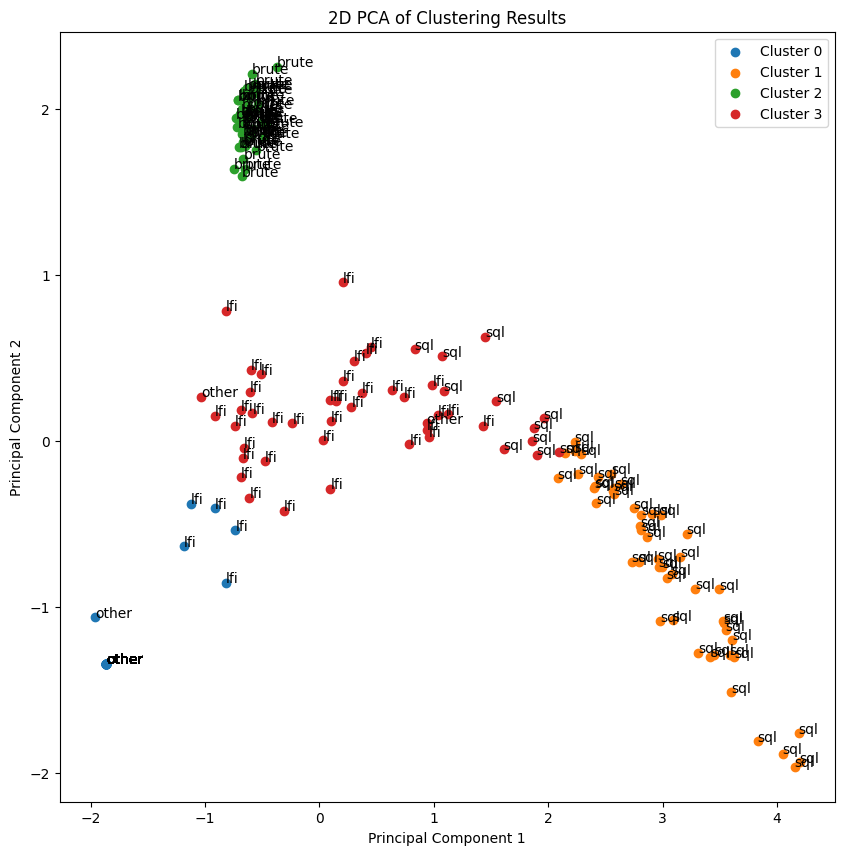

In [13]:
# 每個群隨機選 50 個資料點，將資料點視覺化 (顏色)
plt.figure(figsize=(10, 10))
selected_indices = []
for cluster in range(num_clusters):
    points = reduced_embeddings[clusters == cluster]
    cluster_indices = np.where(clusters == cluster)[0]
    if len(points) > 50:
        selected = np.random.choice(len(points), 50, replace=False)
        points = points[selected]
        cluster_indices = cluster_indices[selected]
    selected_indices.extend(cluster_indices)
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster}')

# 標示每個資料點的攻擊類型 (文字)
for i in selected_indices:
    plt.annotate(train_dataset['label'][i], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))


plt.title('2D PCA of Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### 評估效果

In [14]:
# 計算每個群的平均 embedding
cluster_avg_embeddings = np.zeros((num_clusters, embeddings.shape[1]))

for cluster in range(num_clusters):
    cluster_embeddings = embeddings[clusters == cluster]
    cluster_avg_embeddings[cluster] = np.mean(cluster_embeddings, axis=0)

In [15]:
# 計算每個資料點與各群平均 embedding 的向量相似度 (cosine similarity)，找出最相似的群，紀錄於 result_matrix
cluster_names = list(set(train_dataset['label']))

result_matrix = np.zeros((num_clusters, num_clusters))

for i, embed in tqdm(enumerate(embeddings)):
    similarity_to_cluster = []
    for cluster in range(num_clusters):
        similarity = cosine_similarity(
            embed.reshape(1, -1), cluster_avg_embeddings[cluster].reshape(1, -1)
        )
        similarity_to_cluster.append(similarity[0][0])
    predict = np.argmax(similarity_to_cluster)
    result_matrix[predict, cluster_names.index(train_dataset['label'][i])] += 1

9000it [00:23, 378.14it/s]


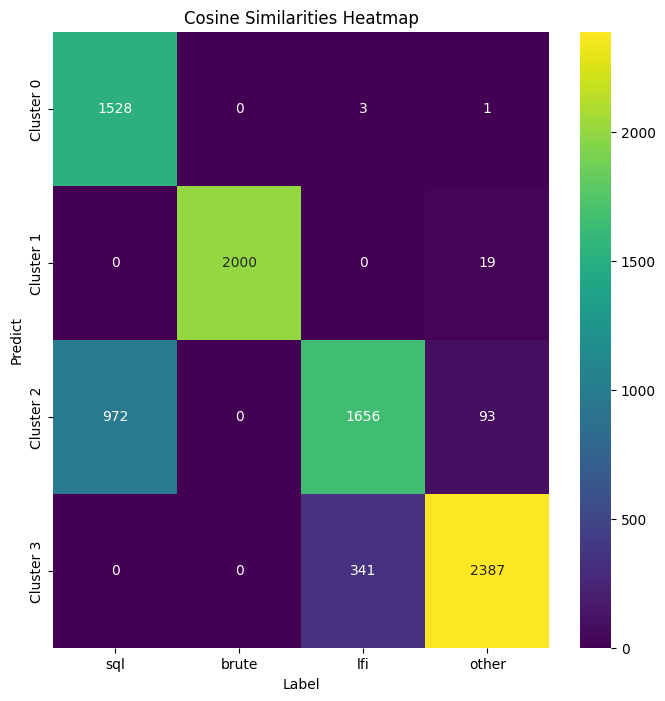

In [16]:
# 顯示 result_matrix
def sort_rows_by_max_column(result_matrix):
    sorted_indices = np.argmax(result_matrix, axis=0)
    return result_matrix[sorted_indices]

result_matrix = sort_rows_by_max_column(result_matrix)

plt.figure(figsize=(8, 8))
sns.heatmap(
    result_matrix,
    annot=True,
    fmt='g',
    cmap='viridis',
    xticklabels=cluster_names,
    yticklabels=[f'Cluster {i}' for i in range(num_clusters)]
)
plt.title('Cosine Similarities Heatmap')
plt.xlabel('Label')
plt.ylabel('Predict')
plt.show()

In [17]:
# 根據 result_matrix 計算 accuracy
accuracy = sum(result_matrix[i][i] for i in range(num_clusters)) / len(train_dataset['data'])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.84


### 微調大型語言模型

In [18]:
# 微調大型語言模型，利用 ContrastiveLoss 訓練大型語言模型，使相同攻擊類型的 embedding 越相似越好，不同的越不相似越好
class FinetuneDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.label_to_int = {label: i for i, label in enumerate(set(labels))}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        text = self.texts[i]
        label = self.labels[i]
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(self.label_to_int[label])
        return inputs

class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()

    def forward(self, embeddings, labels):
        batch_size = embeddings.size(0)
        distances = torch.cdist(embeddings, embeddings, p=2)

        # Correctly handle the labels for creating the mask
        labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]
        mask = labels == labels.T     # Shape: [batch_size, batch_size]

        # Compute positive distances (same label)
        positive_distances = distances[mask]

        # Compute negative distances (different label)
        negative_distances = distances[~mask]

        # Compute the loss
        loss_positive = positive_distances.mean()
        loss_negative = torch.clamp(1.0 - negative_distances, min=0.0).mean()

        return loss_positive + loss_negative

def get_finetune_model(finetune_dataset, tokenizer):
    dataset = FinetuneDataset(finetune_dataset['data'], finetune_dataset['label'], tokenizer)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = DistilBertModel.from_pretrained(LLM_NAME).to(device)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    # Training Loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader, leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            embeddings = model(input_ids, attention_mask).last_hidden_state[:, 0, :]
            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return model

finetune_model = get_finetune_model(finetune_dataset, tokenizer)

Epoch 1/3, Loss: 1.2126


Epoch 2/3, Loss: 0.4480


Epoch 3/3, Loss: 0.3172


In [19]:
# 將 http request 輸入微調後的大型語言模型，得到其 embeddings
embeddings = []
for text in tqdm(train_dataset['data']):
    embedding = get_embedding_of_text(text, tokenizer, finetune_model, device)
    embeddings.append(embedding)
embeddings = np.vstack(embeddings)

100%|██████████| 9000/9000 [01:01<00:00, 145.94it/s]


In [20]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
clusters = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [21]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

explained_variance_ratio = pca.explained_variance_ratio_
info_loss = 1 - np.sum(explained_variance_ratio)
print(f'PCA Info Loss: {info_loss:.2f}')

PCA Info Loss: 0.27


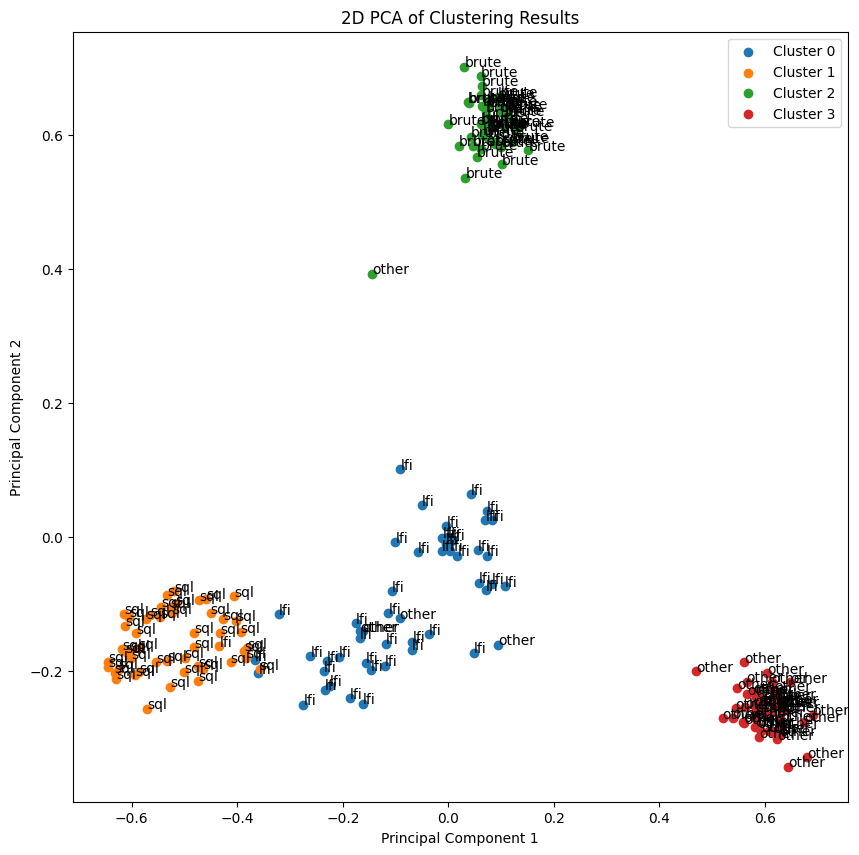

In [22]:
# 每個群隨機選 50 個資料點，將資料點視覺化 (顏色)
plt.figure(figsize=(10, 10))
selected_indices = []
for cluster in range(num_clusters):
    points = reduced_embeddings[clusters == cluster]
    cluster_indices = np.where(clusters == cluster)[0]
    if len(points) > 50:
        selected = np.random.choice(len(points), 50, replace=False)
        points = points[selected]
        cluster_indices = cluster_indices[selected]
    selected_indices.extend(cluster_indices)
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster}')

# 標示每個資料點的攻擊類型 (文字)
for i in selected_indices:
    plt.annotate(train_dataset['label'][i], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))


plt.title('2D PCA of Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [23]:
# 計算每個群的平均 embedding
cluster_avg_embeddings = np.zeros((num_clusters, embeddings.shape[1]))

for cluster in range(num_clusters):
    cluster_embeddings = embeddings[clusters == cluster]
    cluster_avg_embeddings[cluster] = np.mean(cluster_embeddings, axis=0)

In [24]:
# 計算每個資料點與各群平均 embedding 的向量相似度 (cosine similarity)，找出最相似的群，紀錄於 result_matrix
cluster_names = list(set(train_dataset['label']))

result_matrix = np.zeros((num_clusters, num_clusters))

for i, embed in tqdm(enumerate(embeddings)):
    similarity_to_cluster = []
    for cluster in range(num_clusters):
        similarity = cosine_similarity(
            embed.reshape(1, -1), cluster_avg_embeddings[cluster].reshape(1, -1)
        )
        similarity_to_cluster.append(similarity[0][0])
    predict = np.argmax(similarity_to_cluster)
    result_matrix[predict, cluster_names.index(train_dataset['label'][i])] += 1

9000it [00:20, 449.09it/s]


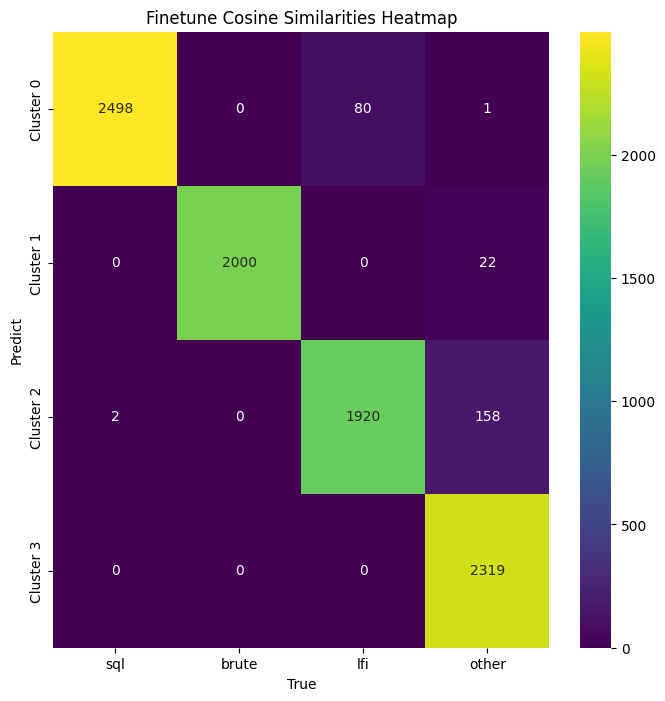

In [25]:
# 顯示 result_matrix
result_matrix = sort_rows_by_max_column(result_matrix)

plt.figure(figsize=(8, 8))
sns.heatmap(
    result_matrix,
    annot=True,
    fmt='g',
    cmap='viridis',
    xticklabels=cluster_names,
    yticklabels=[f'Cluster {i}' for i in range(num_clusters)]
)
plt.title('Finetune Cosine Similarities Heatmap')
plt.xlabel('True')
plt.ylabel('Predict')
plt.show()

In [26]:
# 根據微調大型語言模型後的 accuracy
accuracy = sum(result_matrix[i][i] for i in range(num_clusters)) / len(train_dataset['data'])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97


### 利用 Significant Token 找出攻擊特徵

In [27]:
# 視覺化大型語言模型切出來的 tokens
def visualize_tokens_html(tokens, colors=[]):
    html = "<div style='font-family: monospace;'>"
    for i, token in enumerate(tokens):
        color = f'#{random.randint(0, 0xFF8888):06x}'
        if colors:
            color = colors[i]
        html += f"<span style='display: inline-block; color: {color}; border: 1px solid {color}; padding: 2px; margin: 2px;'>{token}</span> "
    html += "</div>"
    display(HTML(html))

selected_indices = []
for cluster in range(num_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    selected_indices.append(np.random.choice(cluster_indices))

for i in selected_indices:
    text = train_dataset['data'][i]
    print(text)
    tokenized_text = tokenizer(text, return_offsets_mapping=True)
    tokens = tokenized_text.tokens()
    visualize_tokens_html(tokens)
    print('')

GET /path?page=.?\.?\etc\issue HTTP/1.1



GET /path?id=1&Submit=-4223%22%29%20OR%20EXTRACTVALUE%284922%2CCASE%20WHEN%20%284922%3D4922%29%20THEN%204922%20ELSE%200x3A%20END%29%20AND%20%28%22hpmX%22%20LIKE%20%22hpmX HTTP/1.1



POST /path HTTP/1.0
Content-Type: application/x-www-form-urlencoded

username=FSFTASK2&password=pass&Login=Login



GET /path HTTP/1.1


In [28]:
# 根據我們理想的方式切分 tokens，得到 ideal_tokens
def parse_http_req(raw_request):
    # Split the request into lines
    lines = raw_request.split('\n')

    # Parse the request line
    request_line = lines[0].split(' ')
    method = request_line[0]
    path = request_line[1]
    version = request_line[2] if len(request_line) > 2 else ""

    # Parse the headers
    headers = {}
    i = 1
    while i < len(lines) and lines[i] != '':
        header_name, header_value = lines[i].split(': ', 1)
        headers[header_name] = header_value
        i += 1

    # If it's a POST request, the body starts after the empty line
    body = ''
    if method == 'POST':
        i += 1  # Skip the empty line
        body = '\n'.join(lines[i:])

    # Parse the URL and raw query parameters without URL decoding
    parsed_url = urlparse(path)
    raw_query = parsed_url.query
    query_params = [tuple(param.split('=', 1)) for param in raw_query.split('&') if '=' in param]

    # Parse the raw body parameters for POST requests
    raw_body_params = []
    if method == 'POST' and headers.get('Content-Type') == 'application/x-www-form-urlencoded':
        raw_body_params = [tuple(param.split('=', 1)) for param in body.split('&') if '=' in param]

    return {
        'method': method,
        'path': parsed_url.path,
        'version': version,
        'query_params': query_params,
        'headers': headers,
        'body': body,
        'body_params': raw_body_params
    }

def ideal_tokenize(text):
    d = parse_http_req(text)

    tokens = []
    tokens.append(d['method'])
    tokens.append(d['path'])
    if d['query_params']:
        tokens.append('?')
        for i, (k, v) in enumerate(d['query_params']):
            if i > 0:
                tokens.append('&')
            tokens.append(k)
            tokens.append('=')
            tokens.append(v)
    tokens.append(d['version'])
    for k, v in d['headers'].items():
        tokens.append(k)
        tokens.append(':')
        tokens.append(v)
    for i, (k, v) in enumerate(d['body_params']):
        if i > 0:
            tokens.append('&')
        tokens.append(k)
        tokens.append('=')
        tokens.append(v)

    return tokens

for i in selected_indices:
    text = train_dataset['data'][i]
    ideal_tokens = ideal_tokenize(text)
    visualize_tokens_html(ideal_tokens)
    print('')

In [30]:
# 計算每個 ideal_token 對該 embedding 分配至其所屬群的影響程度

def get_color(sim_loss):
    sim_loss = (sim_loss+1) / 2
    color = plt.cm.bwr(sim_loss)  # Blue-White-Red colormap
    return f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'

def normalize_losses(losses):
    losses = np.array(losses)
    abs_losses = np.abs(losses)
    #min_abs = abs_losses.min()
    min_abs = 0.
    max_abs = abs_losses.max()
    normalized_abs_losses = (abs_losses - min_abs) / (max_abs - min_abs)
    normalized_losses = np.sign(losses) * normalized_abs_losses

    #print(normalized_losses)
    return normalized_losses

for cluster_i, i in enumerate(selected_indices):
    embedding = embeddings[i].reshape(1, -1)
    similarities = cosine_similarity(embedding, cluster_avg_embeddings)
    similarities = similarities.flatten()
    orig_sim = similarities[cluster_i]   # embedding 與其所屬群的平均 embedding 的相似程度

    sim_losses = []
    ideal_tokens = ideal_tokenize(train_dataset['data'][i])
    for idx_to_remove in range(len(ideal_tokens)):
        modified_text = ideal_tokens[:idx_to_remove] + ideal_tokens[idx_to_remove+1:]
        modified_text = ' '.join(modified_text)
        modified_embedding = get_embedding_of_text(modified_text, tokenizer, finetune_model, device, disable_tqdm=True).reshape(1, -1)

        new_similarities = cosine_similarity(modified_embedding, cluster_avg_embeddings)
        new_similarities = new_similarities.flatten()
        new_sim = new_similarities[cluster_i]  # 移除一個 ideal token 後，與其所屬群的平均 embedding 的相似程度

        sim_loss = orig_sim - new_sim
        sim_losses.append(sim_loss)
        #print(f'Sim Loss: {sim_loss:.8f}')
    #print("\n")

    print('cluster', cluster_i)
    visualize_tokens_html(ideal_tokens, [get_color(loss) for loss in normalize_losses(sim_losses)])

cluster 0


cluster 1


cluster 2


cluster 3
